# About this notebook
* Plugs in Worldview-3 orthoimages & ASP stereo DSM + Baker 2015 lidar DSMs to ResDepth code release https://github.com/stuckerc/ResDepth
* Assumes dem_align.py was already run to align stereo DEM to lidar, with glaciers masked out
* Calls the ResDepth training script to train models on chunks of the dataset
* Visualize model output for training & unseen areas

## Imports

In [77]:
!pip install matplotlib-scalebar

In [1]:
import json
import os.path
import pickle

import rioxarray

import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

from osgeo import gdal
gdal.UseExceptions()
from osgeo.gdal import GA_Update

# Resdepth
import torch
import torchvision
import sys
sys.path.insert(0, "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/ResDepth/")
from lib.UNet import UNet


### Raster filepaths

In [2]:
# Using 2015 Baker lidar DSM
data_dir = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/data"
lidar_dem_fn = f"{data_dir}/baker_2015_utm_m.tif"

# Switched again to the 20150911 stereo pair
# Arbitrary stereo1 & stereo2 for now
ortho_20150911_fn1 = f"{data_dir}/1020010042D39D00_ortho_0.54m.tif"
ortho_20150911_fn2 = f"{data_dir}/1020010043455300_ortho_0.54m.tif"

# Stereo DEM that went through dem_align.py with glaciers masked out
stereo_20150911_fn = f"{data_dir}/20150911_2050_1020010042D39D00_1020010043455300-DEM_1.08m_dzfilt_-200_200_baker_2015_utm_m_nuth_x+3.12_y+2.41_z-3.27_align.tif"

### Apply XY offset to 20150911 orthoimages

In [3]:
ds1 = gdal.Open(ortho_20150911_fn1, GA_Update)
ds2 = gdal.Open(ortho_20150911_fn2, GA_Update)
dx_20150911, dy_20150911, dz_20150911 = (3.12, 2.41, -3.27)
print("Existing transforms", ds1.GetGeoTransform(), ds2.GetGeoTransform())
assert 0 # already did this step, uncommented this
# Just hardcode it for now so I'm not shifting repeatedly by dx+dy
# shifted_transform_20150928 = list(ds1.GetGeoTransform())
# shifted_transform_20150928[0] += dx_20150928
# shifted_transform_20150928[3] += dy_20150928
# print(shifted_transform_20150928)
shifted_transform_20150911 = (577145.25 + dx_20150911, 0.54, 0.0, 5412174.03 + dy_20150911, 0.0, -0.54)
ds1.SetGeoTransform(shifted_transform_20150911)
ds2.SetGeoTransform(shifted_transform_20150911)
print("Set orthoimages to new geotransform:", ds1.GetGeoTransform(), ds2.GetGeoTransform())
ds1 = None
ds2 = None
!ls -l "$ortho_20150911_fn1" "$ortho_20150911_fn2"

Existing transforms (577148.37, 0.54, 0.0, 5412176.44, 0.0, -0.54) (577148.37, 0.54, 0.0, 5412176.44, 0.0, -0.54)


AssertionError: 

### Fill nodata (in-place) for 20150911 DEM

In [80]:
!gdal_fillnodata.py -md 500 "$stereo_20150911_fn"

osgeo __init__.py importlib for mname= osgeo._gdal
imported mname osgeo._gdal
0...10...20...30...40...50...60...70...80...90...100 - done.


### 20150911 set extent & resolution - vegetation, open & treed slopes south of Easton Glacier

In [4]:
# ulx, uly = 583889.8,5399450.0
# lrx, lry = 588135.5,5396147.2
# area_name = "veg_slopes_south_of_easton"
# ulx, uly, lrx, lry, area_name = (584000, 5404000, 589000, 5401000, "baker_summit_glaciers_small") # glaciers focus on 1/6 the full area
# ulx, uly, lrx, lry, area_name = (584000, 5407000, 589000, 5404000, "glaciers_north_of_baker_small") # small glaciated area north of the summit
# 579550,5413544 very top left of GT as far left as can go without hole
# 591732,5399265 bottom right above hole
ulx, uly, lrx, lry, area_name = (582160,5411392, 591528,5394757, "baker_largest_bbox")

In [5]:
with rioxarray.open_rasterio(lidar_dem_fn) as lidar_dem:
    print(lidar_dem_fn)
    print(lidar_dem.rio.crs)
    xres, yres = lidar_dem.rio.resolution()
    print(f"using xres={xres}, yres={yres}")

data/baker_2015_utm_m.tif
EPSG:32610
using xres=0.9135309646378489, yres=-0.9135309646378489


### gdalwarp 20150911 calls

In [6]:
# Filenames for training (TODO: save copy of these rasters)
gt_dem_fn = "rd_gt_dem.tif"
initial_dem_fn = "rd_initial_dem.tif"
ortho1_fn = "rd_ortho1.tif"
ortho2_fn = "rd_ortho2.tif"

# Overwrite existing rasters that don't have specific name
!rm rd*.tif

# Lidar, only want to crop
!gdalwarp -te $ulx $lry $lrx $uly -tr $xres $yres -r cubic -co COMPRESS=LZW "$lidar_dem_fn" "$gt_dem_fn"

# Stereo (nodata already filled)
!gdalwarp -te $ulx $lry $lrx $uly -tr $xres $yres -r cubic -co COMPRESS=LZW "$stereo_20150911_fn" "$initial_dem_fn"

# Orthoimages (already offset)
!gdalwarp -te $ulx $lry $lrx $uly -tr $xres $yres -r cubic -co COMPRESS=LZW "$ortho_20150911_fn1" "$ortho1_fn"
!gdalwarp -te $ulx $lry $lrx $uly -tr $xres $yres -r cubic -co COMPRESS=LZW "$ortho_20150911_fn2" "$ortho2_fn"

# Check that files were created with expected size
!ls -l rd*.tif

Creating output file that is 10255P x 18210L.
Processing data/baker_2015_utm_m.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image data/baker_2015_utm_m.tif.
Copying nodata values from source data/baker_2015_utm_m.tif to destination rd_gt_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 10255P x 18210L.
Processing data/20150911_2050_1020010042D39D00_1020010043455300-DEM_1.08m_dzfilt_-200_200_baker_2015_utm_m_nuth_x+3.12_y+2.41_z-3.27_align.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image data/20150911_2050_1020010042D39D00_1020010043455300-DEM_1.08m_dzfilt_-200_200_baker_2015_utm_m_nuth_x+3.12_y+2.41_z-3.27_align.tif.
Copying nodata values from source data/20150911_2050_1020010042D39D00_1020010043455300-DEM_1.08m_dzfilt_-200_200_baker_2015_utm_m_nuth_x+3.12_y+2.41_z-3.27_align.tif to destination rd_initial_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 10255P

### Save a copy of these rasters to separate folder

In [7]:
dataset_main_dir = "resdepth_datasets"
dataset_dest_dir = f"{dataset_main_dir}/{area_name}"
!mkdir -p "$dataset_dest_dir"
!cp "$gt_dem_fn" "$initial_dem_fn" "$ortho1_fn" "$ortho2_fn" "$dataset_dest_dir"

### Set up Resdepth configuration with our rasters

In [3]:
!echo "rd_ortho1.tif, rd_ortho2.tif" > pairlist_stereo.txt
!echo "rd_ortho1.tif" > imagelist.txt
!echo "rd_ortho2.tif" >> imagelist.txt
raster_gt = "rd_gt_dem.tif"
raster_in = "rd_initial_dem.tif"
path_image_list = "imagelist.txt"
path_pairlist_training = "pairlist_stereo.txt"

resdepth_config = {
  "datasets": [
    {
      "name": "my_dataset",
      "raster_gt": raster_gt,
      "raster_in": raster_in,
      "path_image_list": "imagelist.txt",
      "path_pairlist_training": "pairlist_stereo.txt",
      "path_pairlist_validation": "pairlist_stereo.txt",
      "area_type": "train+val",
      "allocation_strategy": "5-crossval_vertical",
      "test_stripe": 1,
      "n_training_samples": 5000, # TODO change back #1000, #20000,
      "crossval_training": False
    }
    ],
  "model": {
    "input_channels": "geom-stereo"
  },
  "stereopair_settings": {
    "use_all_stereo_pairs": True,
    "permute_images_within_pair": False
  },
  "training_settings": {
    "tile_size": 256,
    "augment": True, # TODO change back to True, want augmentation after overfit
    "batch_size": 20, # TODO change back to 20, #1
    "n_epochs": 2000,
    "loss": "L1"
  },
  "optimizer": {
    "name": "Adam",
    "learning_rate": 0.0002
  },
  "scheduler": {
    "name": "StepLR",
    "enabled": True,
    "settings": {
      "step_size": 200
    }
  },
  "general": {
    "save_model_rate": 5, #TODO saving too many checkpoints just for debug
    "evaluate_rate": 1,
    "workers": 2, # TODO added due to colab warning
  },
  "output": {
    "suffix": "ResDepth-stereo",
    "output_directory": "resdepth-output",
    "tboard_log_dir": "resdepth-output"
  }
}

with open("config.json", "w") as f:
    json.dump(resdepth_config, f)

### Run train.py (or do this outside notebook)

In [3]:
!python ResDepth/train.py config.json

Traceback (most recent call last):
  File "/home/sethv/miniconda3/envs/py39/lib/python3.9/site-packages/osgeo/__init__.py", line 21, in swig_import_helper
    return importlib.import_module(mname)
  File "/home/sethv/miniconda3/envs/py39/lib/python3.9/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 666, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 565, in module_from_spec
  File "<frozen importlib._bootstrap_external>", line 1173, in create_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
ImportError: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by /home/sethv/miniconda3/e

## Load & call "best" Resdepth model on some example input

In [4]:
# run_folder = "./resdepth-output/2021-09-27_14-59_ResDepth-stereo/"
# run_folder = "./resdepth-output/2021-09-29_14-33_ResDepth-stereo/"
run_folder = "./resdepth-output/2021-09-30_14-15_ResDepth-stereo/"

In [5]:
# Load some tiles within easton_area_bounds
# Visualize tiles going into UNet
# Visualize output
# run_folder = "/content/drive/MyDrive/resdepth-save/2021-09-14_20-48_ResDepth-stereo"#2021-09-14_18-04_ResDepth-stereo"
# run_ckpt = "lightning_logs/version_23/checkpoints/epoch=562-step=2815.ckpt"
ckpt = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/deep-elevation-refinement/ResDepth/torchgeo_experiments/tb_logs/resdepth_torchgeo/version_14/checkpoints/epoch=870-step=217750.ckpt"
# run_name = os.path.basename(run_folder) # save this for plotting
# !ls -l $run_folder/checkpoints
resdepth_state_dict = torch.load(ckpt)
# resdepth_state_dict = torch.load(run_folder + "/checkpoints/Model_best.pth")
print("Loaded best model from epoch", resdepth_state_dict['epoch'])
model_args = {'n_input_channels': 3, 'start_kernel': 64, 'depth': 5, 'act_fn_encoder': 'relu', 'act_fn_decoder': 'relu', 'act_fn_bottleneck': 'relu', 'up_mode': 'transpose', 'do_BN': True, 'outer_skip': True, 'outer_skip_BN': False, 'bias_conv_layer': True}
checkpoint_model = UNet(**model_args)
# checkpoint_model.load_state_dict(resdepth_state_dict["state_dict"])
checkpoint_model.load_state_dict({k[5:]:v for k,v in resdepth_state_dict["state_dict"].items()}) # cut off the 'unet.' in state dict???
checkpoint_model.eval()
0

Loaded best model from epoch 870


0

### Load all rasters with rioxarray to send to Resdepth model

In [6]:
# TODO use sample_test_data_dir
test_area_name = "baker_largest_bbox"
test_datasets_dir = "/mnt/1.0_TB_VOLUME/sethv/resdepth_all/resdepth_datasets"
test_dataset_dir = f"{test_datasets_dir}/{test_area_name}"
gt = rioxarray.open_rasterio(f"{test_dataset_dir}/rd_gt_dem.tif") #"/content/lidar_roi_resampled_1m.tif")
# !gdalinfo rd_gt_dem.tif
print(gt.shape)
initial_dsm = rioxarray.open_rasterio(f"{test_dataset_dir}/rd_initial_dem.tif") #"/content/stereo_roi_resampled_1m_interpolated.tif")
print(initial_dsm.shape)
ortho_1 = rioxarray.open_rasterio(f"{test_dataset_dir}/rd_ortho1.tif") #"/content/ortho_10400100110E9600_roi_resampled_1m.tif")
print(ortho_1.shape)
ortho_2 = rioxarray.open_rasterio(f"{test_dataset_dir}/rd_ortho2.tif") #"/content/ortho_1040010011B0B900_roi_resampled_1m.tif")
print(ortho_2.shape)
xres, yres = gt.rio.resolution()

(1, 18210, 10255)
(1, 18210, 10255)
(1, 18210, 10255)
(1, 18210, 10255)


In [9]:
# TODO copied from previous experiment, curious
dsm_mean_std = {'mean': None, 'std': 33.336839170631755}
dsm_std = dsm_mean_std["std"]
ortho_mean_std = {'mean': 261.1999816894531, 'std': 245.63670349121094}
ortho_mean = ortho_mean_std["mean"]
ortho_std = ortho_mean_std["std"]


In [8]:
with open(os.path.join(run_folder, "DSM_normalization_parameters.p"), 'rb') as fid:
    dsm_params = pickle.load(fid)
    dsm_std = dsm_params["std"]

print(dsm_params)

with open(os.path.join(run_folder, "Image_normalization_parameters.p"), 'rb') as fid:
    ortho_params = pickle.load(fid)
    ortho_mean = ortho_params["mean"]
    ortho_std = ortho_params["std"]

print(ortho_params)

FileNotFoundError: [Errno 2] No such file or directory: './resdepth-output/2021-09-30_14-15_ResDepth-stereo/DSM_normalization_parameters.p'

In [10]:

# dsm_params = pickle.load(open("/content/drive/MyDrive/resdepth-save/2021-09-14_07-46_ResDepth-stereo/DSM_normalization_parameters.p"))
# image_params = pickle.load(open("/content/drive/MyDrive/resdepth-save/2021-09-14_07-46_ResDepth-stereo/Image_normalization_parameters.p"))

# Compute standard deviation over all centered DSM training patches...

# Standard deviation:	36.818 m


def call_model(model, inputs):
    """Helper: given pytorch model & input rasters, return model output as numpy array"""
    model_input = np.stack(inputs)
    # print(model_input.shape)
    model_input_tensor = torch.tensor(model_input).unsqueeze(0)
    tile_output = model(model_input_tensor).detach().numpy().squeeze()
    return tile_output

def call_and_plot_resdepth_on_tile(model, x, y, initial_dsm, ortho_1, ortho_2, gt, scale=None, fixed_vmax=2, tile_size=256, plot=True, caption=""):
    # Split into separate functions
    tile_dsm = initial_dsm[0,y:y+tile_size,x:x+tile_size]

    tile_ortho_1 = ortho_1[0,y:y+tile_size,x:x+tile_size]
    tile_ortho_2 = ortho_2[0,y:y+tile_size,x:x+tile_size]
    tile_gt = gt[0,y:y+tile_size,x:x+tile_size]


    # TODO normalize DSM according to the saved parameters
    # normalize satellite images too

    dsm_mean = np.ma.mean(tile_dsm)
    tile_dsm_normalized = torchvision.transforms.Normalize(dsm_mean, dsm_std)(torch.tensor([tile_dsm.data])).numpy().squeeze()

    # TODO bug had to convert to float
    tile_ortho_1_normalized = torchvision.transforms.Normalize(ortho_mean, ortho_std)(torch.tensor([tile_ortho_1.data.astype(np.float32)])).numpy().squeeze()
    tile_ortho_2_normalized = torchvision.transforms.Normalize(ortho_mean, ortho_std)(torch.tensor([tile_ortho_2.data.astype(np.float32)])).numpy().squeeze()
    # tile_dsm = tile_dsm_normalized
    # tile_ortho_1 = tile_ortho_1_normalized
    # tile_ortho_2 = tile_ortho_2_normalized
    # ## TODO Debug^ remove hard-coded values
    
    tile_output = call_model(model, [tile_dsm_normalized,tile_ortho_1_normalized, tile_ortho_2_normalized])
    # model_input = np.stack([tile_dsm,tile_ortho_1, tile_ortho_2])
    # model_input_tensor = torch.tensor(model_input).unsqueeze(0)
    # model_input_tensor.shape

    tile_output = (tile_output * dsm_std) +  dsm_mean # Denormalize output

    # tile_output = checkpoint_model(model_input_tensor).detach().numpy().squeeze()
    tile_output.shape
    
    # # TODO while debugging what is going on with the residual corrections, try adding a weight & bias to resdepth correction
    # w = 0.3 # how bigly to correct the initial DSM
    # b = 100 # meters
    tile_output_modified = None #w * (tile_output + b) + (1-w) * tile_dsm

    caption = f"ResDepth\n(x={x}, y={y})\n"+caption
    #TODO remove the subtraction
    if plot:
        plot_resdepth(tile_dsm, tile_ortho_1, tile_ortho_2, tile_gt, tile_output, scale=scale, fixed_vmax=fixed_vmax, caption=caption)
    return tile_output

In [11]:
def hillshade(array, azimuth=315, angle_altitude=45):
    """Borrow hillshade 
    
    https://github.com/uw-cryo/wv_stereo_processing/blob/54f3e82f313773e57dea8c3af5f05bb69e6b0a68/notebooks/gm_aso_dg_comparison.ipynb"""

    # Source: http://geoexamples.blogspot.com.br/2014/03/shaded-relief-images-using-gdal-python.html

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi / 180.
    altituderad = angle_altitude*np.pi / 180.


    shaded = np.sin(altituderad) * np.sin(slope) \
     + np.cos(altituderad) * np.cos(slope) \
     * np.cos(azimuthrad - aspect)
    return 255*(shaded + 1)/2

In [12]:
xres

0.9135309646378489

In [8]:
# Previous definitions of plot_resdepth

In [11]:
def plot_resdepth(tile_dsm, tile_ortho_1, tile_ortho_2, tile_gt, tile_output, scale=None, fixed_vmax=2, caption="<captiongoeshere>"):
    """
    fixed_vmax - to get consistent color scale for difference maps, set this to 1-2m
    """
    scale = xres
    ncols = 4
    nrows = 2
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols, 5*nrows))
    fig.suptitle(caption)

    ax_dsm = ax[0,0]
    im = ax_dsm.imshow(hillshade(tile_dsm), cmap="gray")
    im = ax_dsm.imshow(tile_dsm, alpha=0.5)
    ax_dsm.set_title("initial depth")
    fig.colorbar(im, ax=ax_dsm)

    # ax_stereoA = ax[0,1]
    # orthos_split = np.zeros_like(tile_ortho_1)
    # tile_ortho_1.shape[0]
    # orthos_split[:,:tile_ortho_1.shape[0]//2] = tile_ortho_1[:,:tile_ortho_1.shape[0]//2]
    # orthos_split[:,tile_ortho_1.shape[0]//2 + 5:] += tile_ortho_2[:,tile_ortho_1.shape[0]//2 + 5:]
    # orthos_split[:,tile_ortho_1.shape[0]//2:tile_ortho_1.shape[0]//2 + 5] = tile_ortho_1.max()
    # im = ax_stereoA.imshow(orthos_split, cmap="gray")
    # ax_stereoA.set_title("stereo pairs/split")
    # fig.colorbar(im, ax=ax_stereoA)
    
    ax_stereoA = ax[0,1]
    im = ax_stereoA.imshow(tile_ortho_1, cmap="gray")
    ax_stereoA.set_title("stereo A")
    fig.colorbar(im, ax=ax_stereoA)

    ax_stereoB = ax[0,2]
    im = ax_stereoB.imshow(tile_ortho_2, cmap="gray")
    ax_stereoB.set_title("stereo B")
    fig.colorbar(im, ax=ax_stereoB)
    
    ax_gt = ax[1,1]
    im = ax_gt.imshow(hillshade(tile_gt), cmap="gray")
    im = ax_gt.imshow(tile_gt, alpha=0.5)
    ax_gt.set_title("Ground Truth Lidar DSM (m)")
    fig.colorbar(im, ax=ax_gt)
    
    ax_output = ax[1,0]
    im = ax_output.imshow(hillshade(tile_output), cmap="gray")
    im = ax_output.imshow(tile_output, alpha=0.5)
    ax_output.set_title("Refined DSM (m)")
    fig.colorbar(im, ax=ax_output)
    
    ax_refined_minus_gt = ax[1,2]
    im = ax_refined_minus_gt.imshow(tile_output-tile_gt, cmap="RdBu", vmin=-1*fixed_vmax, vmax=fixed_vmax)
    ax_refined_minus_gt.set_title(f"Refined - Lidar (median: {float(np.median(tile_output-tile_gt)):.1f}m)")
    fig.colorbar(im, ax=ax_refined_minus_gt)
    
    ax_hist = ax[1,3]
    ax_hist.hist(tile_output-tile_gt)
    # https://github.com/dshean/demcoreg/blob/2b4e9cbcec82e72b96213d734402fa9d3cfba0c5/demcoreg/dem_align.py#L577
    
    # Turn off axis ticks, add scalebar
    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            ax[i,j].add_artist(ScaleBar(scale))

In [13]:
def plot_resdepth(tile_dsm, tile_ortho_1, tile_ortho_2, tile_gt, tile_output, scale=None, fixed_vmax=2, caption="<captiongoeshere>"):
    """
    fixed_vmax - to get consistent color scale for difference maps, set this to 1-2m
    """
    scale = xres
    ncols = 4
    nrows = 2
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5*ncols, 5*nrows))
    fig.suptitle(caption)

    ax_dsm = ax[0,0]
    im = ax_dsm.imshow(hillshade(tile_dsm), cmap="gray")
    im = ax_dsm.imshow(tile_dsm, alpha=0.5)
    ax_dsm.set_title("Initial DSM")
    fig.colorbar(im, ax=ax_dsm)

    # ax_stereoA = ax[0,1]
    # orthos_split = np.zeros_like(tile_ortho_1)
    # tile_ortho_1.shape[0]
    # orthos_split[:,:tile_ortho_1.shape[0]//2] = tile_ortho_1[:,:tile_ortho_1.shape[0]//2]
    # orthos_split[:,tile_ortho_1.shape[0]//2 + 5:] += tile_ortho_2[:,tile_ortho_1.shape[0]//2 + 5:]
    # orthos_split[:,tile_ortho_1.shape[0]//2:tile_ortho_1.shape[0]//2 + 5] = tile_ortho_1.max()
    # im = ax_stereoA.imshow(orthos_split, cmap="gray")
    # ax_stereoA.set_title("stereo pairs/split")
    # fig.colorbar(im, ax=ax_stereoA)
    
    ax_stereoA = ax[0,1]
    im = ax_stereoA.imshow(tile_ortho_1, cmap="gray")
    ax_stereoA.set_title("Stereo-Nadir")
    fig.colorbar(im, ax=ax_stereoA)

    ax_stereoB = ax[0,2]
    im = ax_stereoB.imshow(tile_ortho_2, cmap="gray")
    ax_stereoB.set_title("Stereo-Off Nadir")
    fig.colorbar(im, ax=ax_stereoB)
    
    ax_gt = ax[1,1]
    im = ax_gt.imshow(hillshade(tile_gt), cmap="gray")
    im = ax_gt.imshow(tile_gt, alpha=0.5)
    ax_gt.set_title("Ground Truth Lidar DSM (m)")
    fig.colorbar(im, ax=ax_gt)
    
    ax_output = ax[1,0]
    im = ax_output.imshow(hillshade(tile_output), cmap="gray")
    im = ax_output.imshow(tile_output, alpha=0.5)
    ax_output.set_title("Refined DSM (m)")
    fig.colorbar(im, ax=ax_output)
    
    ax_refined_minus_gt = ax[1,2]
    im = ax_refined_minus_gt.imshow(tile_output-tile_gt, cmap="RdBu", vmin=-1*fixed_vmax, vmax=fixed_vmax)
    ax_refined_minus_gt.set_title(f"Refined - Lidar (median: {float(np.median(tile_output-tile_gt)):.1f}m)")
    fig.colorbar(im, ax=ax_refined_minus_gt)
    
    # ax_initial_hist = ax[0,3]
    # ax_initial_hist.hist((tile_dsm-tile_gt).data.flatten(), color="red", label="initial", bins=1000)
    # ax_initial_hist.set_title("Initial-GT hist (m)")
    # ax_initial_hist.axvline(x=0)
    # ax_initial_hist.set_xlim(-2,2)

    ax_residual = ax[0,3]
    ax_residual.imshow(tile_output-tile_dsm, cmap="RdBu", vmin=-1*fixed_vmax, vmax=fixed_vmax)
    ax_residual.set_title(f"Residual correction (median: {float(np.median(tile_output-tile_dsm)):.1f}m)")
    fig.colorbar(im, ax=ax_residual)


    # Plot histograms of the difference maps to compare initial-gt to refined-gt
    # https://github.com/dshean/demcoreg/blob/2b4e9cbcec82e72b96213d734402fa9d3cfba0c5/demcoreg/dem_align.py#L577
    ax_refined_hist = ax[1,3]
    ax_refined_hist.hist((tile_dsm-tile_gt).data.flatten(), color="red", label='Before', alpha=0.3, bins=250)
    ax_refined_hist.hist((tile_output-tile_gt).data.flatten(), color="blue", label="After", alpha=0.3, bins=250)
    ax_refined_hist.set_title("DSM - LiDAR")
    ax_refined_hist.axvline(x=0, color='k', linewidth=0.5, linestyle=':')
    ax_refined_hist.set_xlim(-5,5)
    ax_refined_hist.set_xlabel('Elev. Diff. (m)')
    ax_refined_hist.set_ylabel('Count (px)')
    ax_refined_hist.text(0.05, 0.95, "Initial", va='top', color='red', transform=ax_refined_hist.transAxes, fontsize=16)
    ax_refined_hist.text(0.05, 0.85, "Refined", va='top', color='blue', transform=ax_refined_hist.transAxes, fontsize=16)
    # before_str = 'Before\nmed: %0.2f\nnmad: %0.2f' % (diff_orig_stats['med'], diff_orig_stats['nmad'])
    # axa[1,3].text(0.05, 0.95, before_str, va='top', color='red', transform=axa[1,3].transAxes, fontsize=8)
    # after_str = 'After\nmed: %0.2f\nnmad: %0.2f' % (diff_align_stats['med'], diff_align_stats['nmad'])
    # axa[1,3].text(0.65, 0.95, after_str, va='top', color='blue', transform=axa[1,3].transAxes, fontsize=8)

    
    # Turn off axis ticks, add scalebar
    for i in range(nrows):
        for j in range(ncols):
            if i == nrows-1 and j == ncols-1:
                # Skip histogram
                continue
            else:
                ax[i,j].set_xticks([])
                ax[i,j].set_yticks([])
                ax[i,j].add_artist(ScaleBar(scale))
            
    plt.tight_layout()

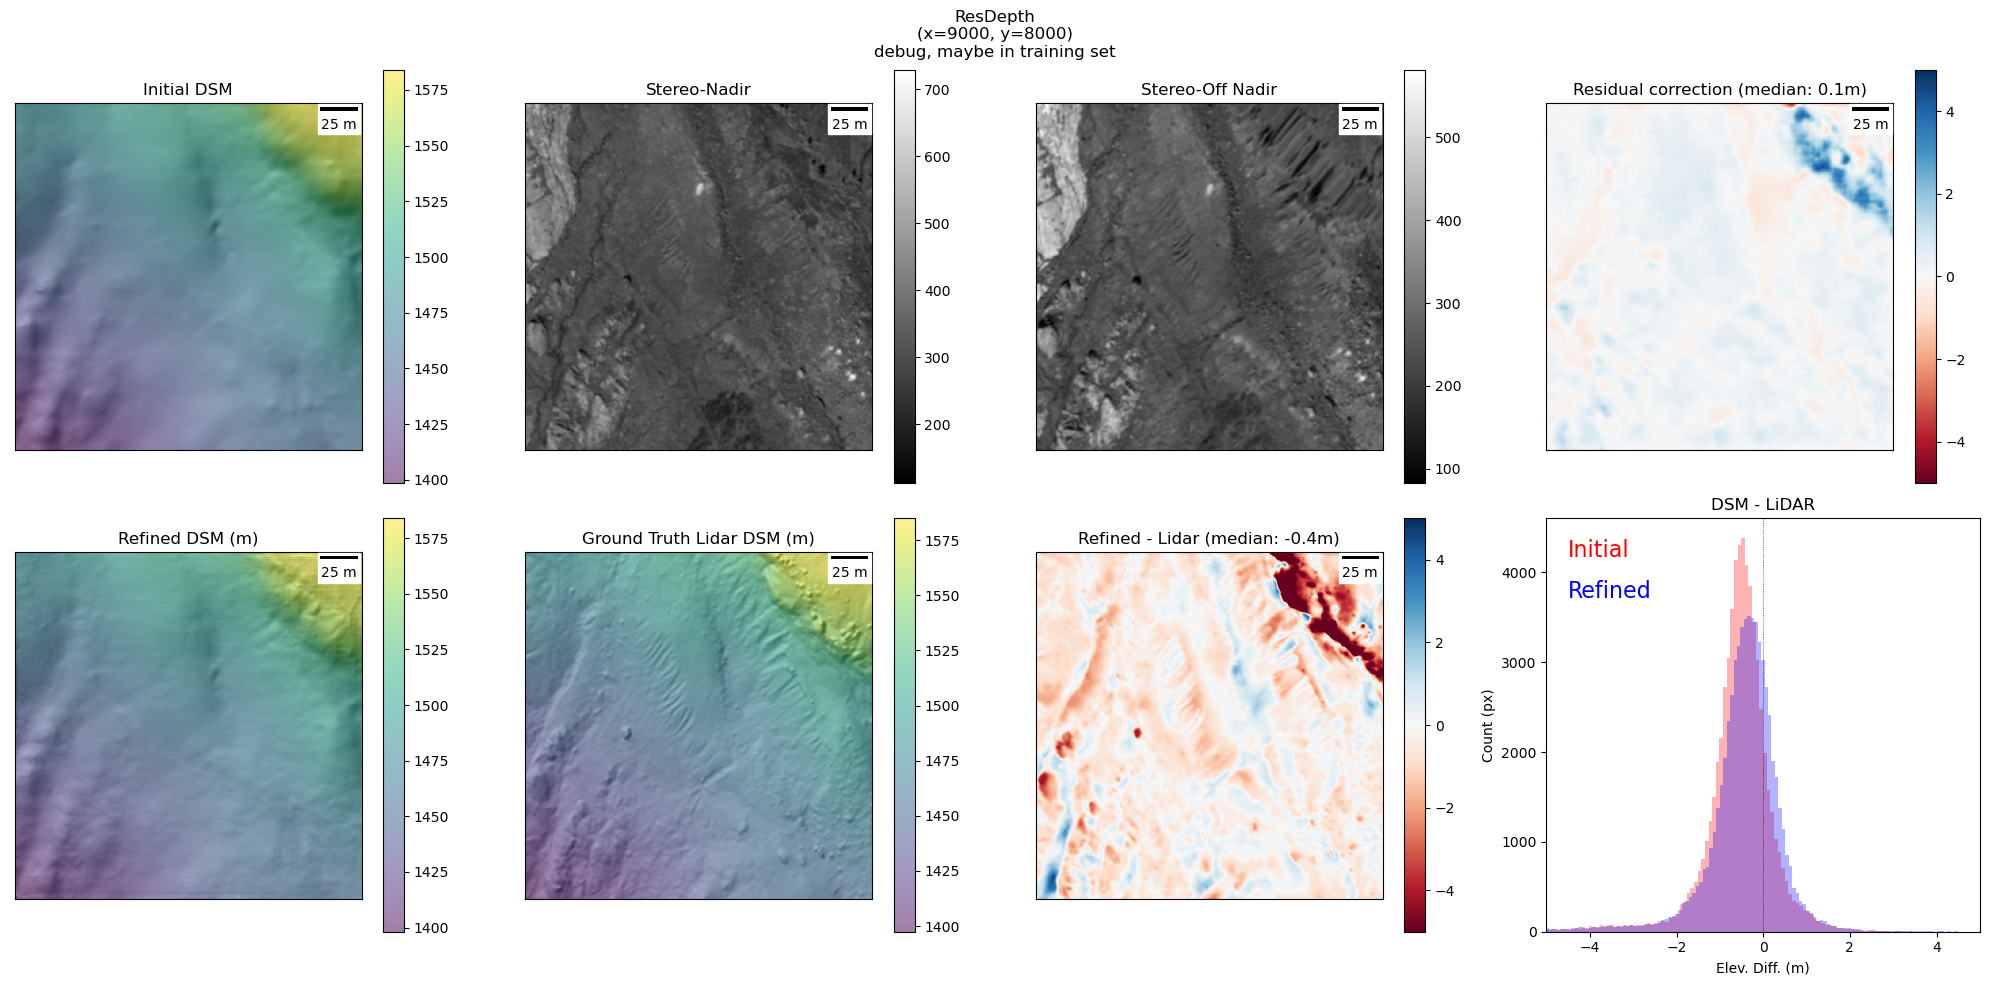

In [17]:
out = call_and_plot_resdepth_on_tile(checkpoint_model, 9000, 8000, initial_dsm, ortho_1, ortho_2, gt, scale=xres, fixed_vmax=5, caption="debug, maybe in training set")





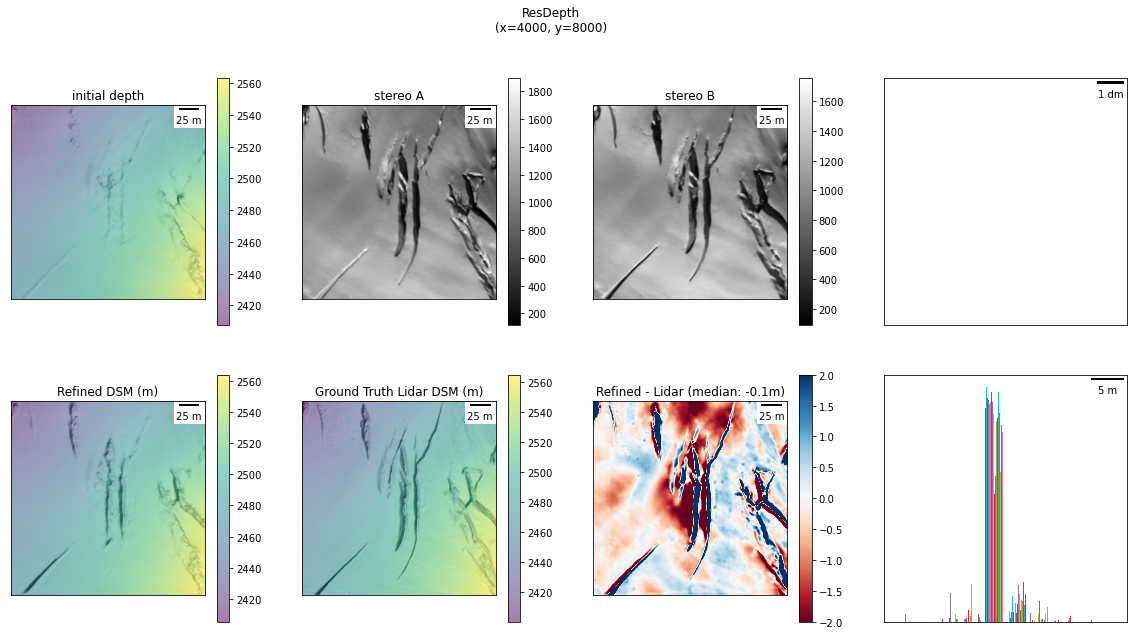

In [76]:
# INTERESTING output 9000,8000 after 43 epochs was putting in the stereo B lines but after 53 learned to not
out = call_and_plot_resdepth_on_tile(checkpoint_model, 4000, 8000, initial_dsm, ortho_1, ortho_2, gt, scale=xres)#2600,2200) #4000,2000 interesting but shadow, 4500,2000 shadow again, 2000,2000 worse

## Call and plot

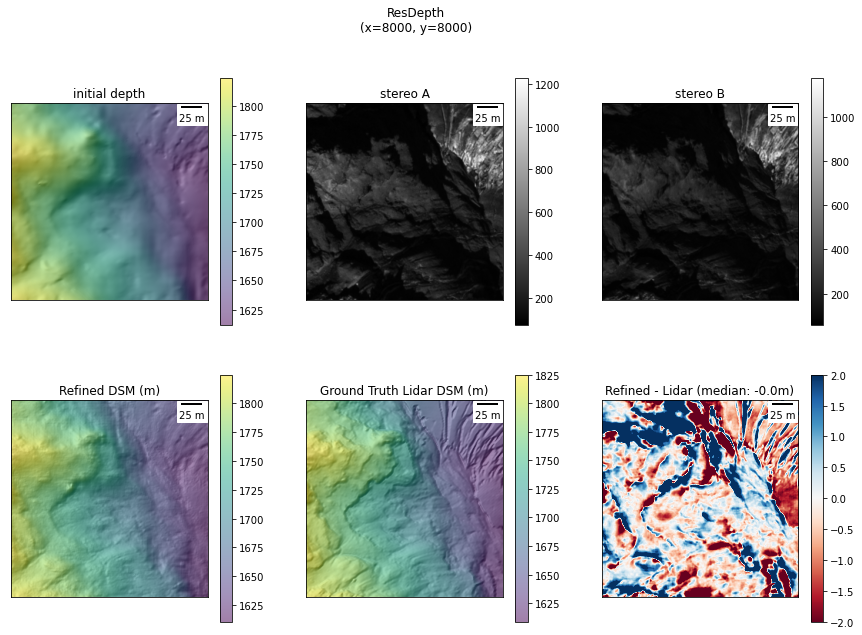

In [67]:
out = call_and_plot_resdepth_on_tile(checkpoint_model, 8000, 8000, initial_dsm, ortho_1, ortho_2, gt, scale=xres)#2600,2200) #4000,2000 interesting but shadow, 4500,2000 shadow again, 2000,2000 worse

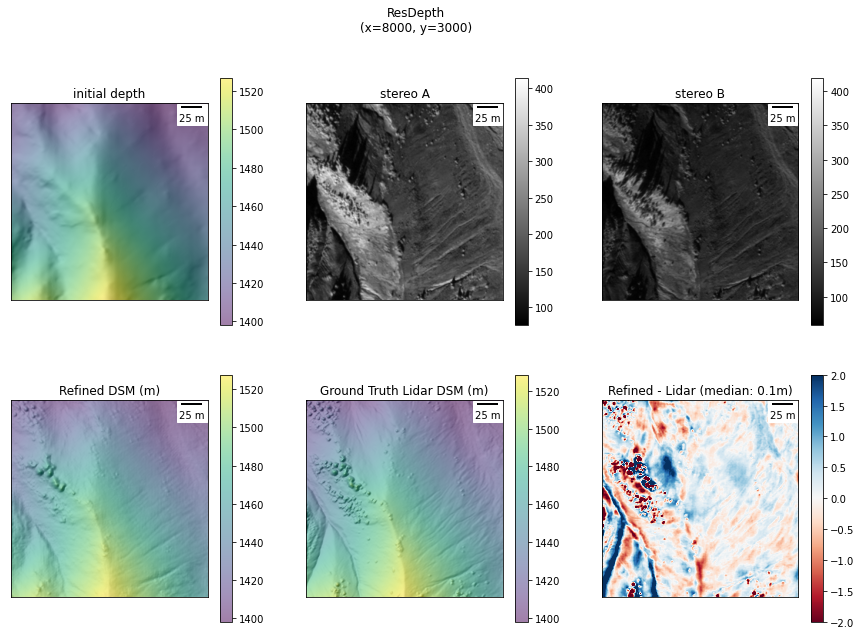

In [71]:
out = call_and_plot_resdepth_on_tile(checkpoint_model, 8000, 3000, initial_dsm, ortho_1, ortho_2, gt, scale=xres)#2600,2200) #4000,2000 interesting but shadow, 4500,2000 shadow again, 2000,2000 worse

### Plot some examples from the validation area [for large bbox: vertical strip with x in (4102,6152)]

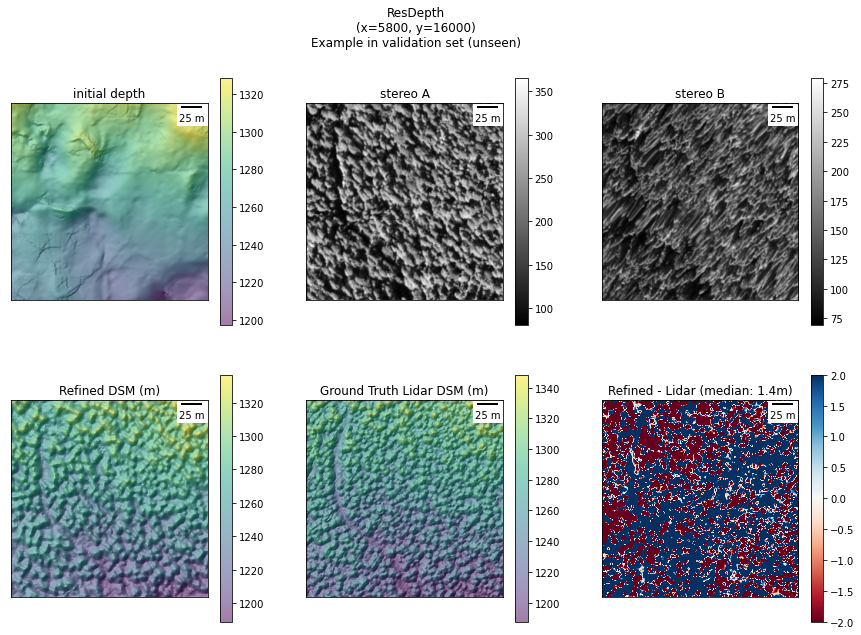

In [72]:
# out = call_and_plot_resdepth_on_tile(checkpoint_model, 5000, 0, initial_dsm, ortho_1, ortho_2, gt, caption="Trees in validation set (unseen)")
out = call_and_plot_resdepth_on_tile(checkpoint_model, 5800, 16000, initial_dsm, ortho_1, ortho_2, gt, scale=xres, caption="Example in validation set (unseen)")
# 5000, 0

(1024, 1024)
tiles w x=0
tiles w x=256
tiles w x=512
tiles w x=768


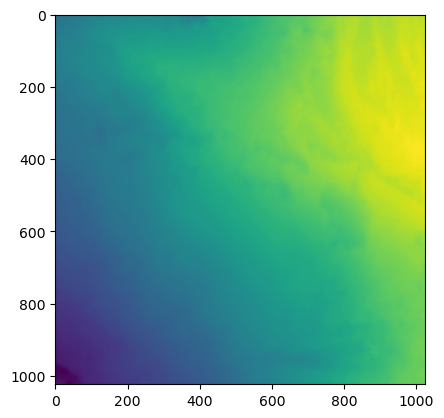

In [24]:
# x = call_and_plot_resdepth_on_tile(0,0, plot=False)
w,h = 1024,1024
collected_refined_dsm = np.zeros((h,w))#np.zeros_like(initial_dsm).squeeze()
print(collected_refined_dsm.shape)
tile_size = 256
for x in range(0,w,tile_size):#collected_refined_dsm.shape[1]-tile_size+1,tile_size):
    print(f"tiles w x={x}")
    for y in range(0,h, tile_size):#collected_refined_dsm.shape[0]-tile_size+1,tile_size):
        # out=call_and_plot_resdepth_on_tile(x,y, plot=False)
        out = call_and_plot_resdepth_on_tile(checkpoint_model, x, y, initial_dsm, ortho_1, ortho_2, gt, plot=False, scale=xres, fixed_vmax=5, caption="debug, maybe in training set")
        collected_refined_dsm[y:y+tile_size,x:x+tile_size] = out


fig, ax = plt.subplots()
ax.imshow(collected_refined_dsm)

In [ ]:
refined_dsm_to_save = initial_dsm.copy()
refined_dsm_to_save.data[0] = collected_refined_dsm

In [ ]:
run_name = os.path.basename(run_folder)
experiment_run = f"{run_name}_veg_south_of_easton_best"
refined_dsm_fn = f"refined_dsm_{experiment_run}.tif"
refined_dsm_to_save.rio.to_raster(refined_dsm_fn)
# refined_dsm_to_save.rio.crs
# !cp "$refined_dsm_fn" "/content/drive/MyDrive/resdepth-save/$run_name"